In [1]:
import scipy
import matplotlib
import numpy as np
import pandas as pd
import numpy.ma as ma
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt

from colors import red
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedShuffleSplit

%matplotlib inline  
DEFAULT_DPI = 600
matplotlib.rcParams['figure.figsize'] = (8, 5)

/home/y_rebryk/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Dataset

In [2]:
def convert(s):
    d = {"пн": 1, "вт": 2, "ср": 3, "чт": 4, "пт": 5, "сб": 6, "вс": 7, "-": 0, "": 0}
    if s in d.keys():
        return d[s]
    else:
        return float(s)

In [3]:
ncols = 140
data = np.genfromtxt("data/dataset_16_3_learn",
                     delimiter="\t", 
                     converters=dict(zip(range(ncols), [convert] * ncols)), 
                     invalid_raise=False)

df = pd.DataFrame(data)

In [4]:
df.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f130,f131,f132,f133,f134,f135,f136,f137,f138,f139
0,NaN,NaN,0.0,NaN,0.0,1.415201e+09,5.0,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,0.0,0.0
1,NaN,NaN,0.0,NaN,0.0,1.415123e+09,6.0,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,0.0,0.0
2,NaN,NaN,0.0,NaN,0.0,1.411383e+09,49.0,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,0.0,0.0
3,NaN,NaN,0.0,NaN,0.0,1.415724e+09,0.0,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,0.0,0.0
4,NaN,NaN,0.0,NaN,0.0,1.415695e+09,0.0,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,0.0,0.0


## Processing

### NaN values

In [5]:
theshold = 0.70
columns_to_remove = []

for index in range(df.shape[1]):
    null_ratio = df.iloc[:, index].isnull().sum() / len(df)
    msg = "Percent of nulls for f{}: {:3.2f}%".format(index, 100 * null_ratio)
    
    if null_ratio:
        if null_ratio > theshold:
            columns_to_remove.append("f{}".format(index))
            
        print(red(msg) if null_ratio > theshold else msg)

Percent of nulls for f0: 100.00%
Percent of nulls for f1: 100.00%
Percent of nulls for f3: 99.37%
Percent of nulls for f6: 3.78%
Percent of nulls for f7: 99.37%
Percent of nulls for f8: 99.37%
Percent of nulls for f12: 76.38%
Percent of nulls for f18: 99.88%
Percent of nulls for f31: 74.23%
Percent of nulls for f33: 74.23%
Percent of nulls for f34: 74.23%
Percent of nulls for f35: 99.38%
Percent of nulls for f36: 74.23%
Percent of nulls for f37: 74.23%
Percent of nulls for f38: 74.23%
Percent of nulls for f39: 74.23%
Percent of nulls for f40: 74.23%
Percent of nulls for f41: 74.23%
Percent of nulls for f42: 74.23%
Percent of nulls for f43: 74.23%
Percent of nulls for f44: 74.23%
Percent of nulls for f45: 74.23%
Percent of nulls for f46: 74.23%
Percent of nulls for f47: 74.23%
Percent of nulls for f48: 74.23%
Percent of nulls for f49: 74.23%
Percent of nulls for f50: 74.23%
Percent of nulls for f58: 74.23%
Percent of nulls for f59: 74.23%
Percent of nulls for f60: 74.23%
Percent of null

In [6]:
df = df.drop(columns_to_remove, axis=1)
df.head()

,f2,f4,f5,f6,f9,f10,f11,f13,f14,f15,...,f105,f118,f120,f121,f134,f135,f136,f137,f138,f139
0,0.0,0.0,1.415201e+09,5.0,0.0,0.0,0.0,25842.0,1.415711e+09,17.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,1.415123e+09,6.0,0.0,0.0,0.0,6989.0,1.415718e+09,18.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,1.411383e+09,49.0,0.0,0.0,0.0,74607.0,1.415654e+09,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,1.415724e+09,0.0,0.0,0.0,0.0,14.0,1.415724e+09,20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,1.415695e+09,0.0,0.0,0.0,0.0,0.0,1.415695e+09,12.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


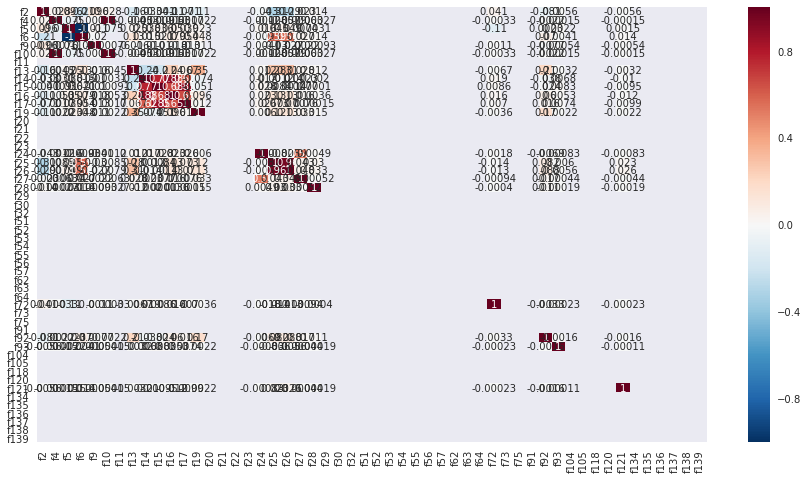

In [7]:
corr = df.corr()

_, ax = plt.subplots(figsize=(15, 8))
sns.heatmap(corr, annot=True, ax=ax)

### Values distribution

In [8]:
treshold = 0.8
columns = df.columns.values

features = set()

for i in range(len(columns)):
    dependent = [j for j in range(i + 1, len(columns)) if corr.iloc[i, j] >= treshold]
    
    if dependent:
        features.add(i)
        
        for it in dependent:
            features.add(it)
        
        print("For {}: {}".format(columns[i], [columns[it] for it in dependent]))

For f4: ['f10']
For f14: ['f16']
For f15: ['f17']
For f25: ['f26']


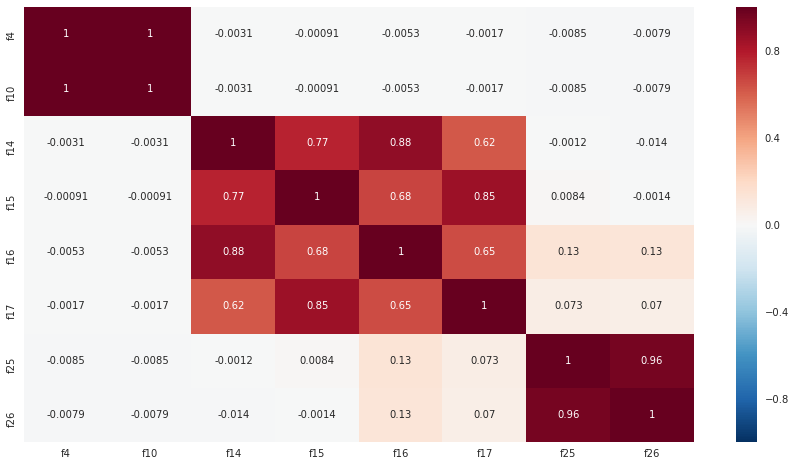

In [9]:
high_corr = corr.iloc[list(features), list(features)]
_, ax = plt.subplots(figsize=(15, 8))
sns.heatmap(high_corr, annot=True, ax=ax)

* We can drop **f4** because it is dependent on **f10**
* We can drop **f14** because it is dependent on **f16**
* We can drop **f15** because it is dependent on **f17**
* We can drop **f25** because it is dependent on **f26**

In [10]:
df = df.drop(["f4", "f14", "f15", "f25"], axis=1)
df.head()

,f2,f5,f6,f9,f10,f11,f13,f16,f17,f19,...,f105,f118,f120,f121,f134,f135,f136,f137,f138,f139
0,0.0,1.415201e+09,5.0,0.0,0.0,0.0,25842.0,1.415737e+09,0.0,17.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,1.415123e+09,6.0,0.0,0.0,0.0,6989.0,1.415725e+09,20.0,175.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,1.411383e+09,49.0,0.0,0.0,0.0,74607.0,1.415729e+09,21.0,77.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,1.415724e+09,0.0,0.0,0.0,0.0,14.0,1.415724e+09,20.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,1.415695e+09,0.0,0.0,0.0,0.0,0.0,1.415695e+09,12.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### Values distributions

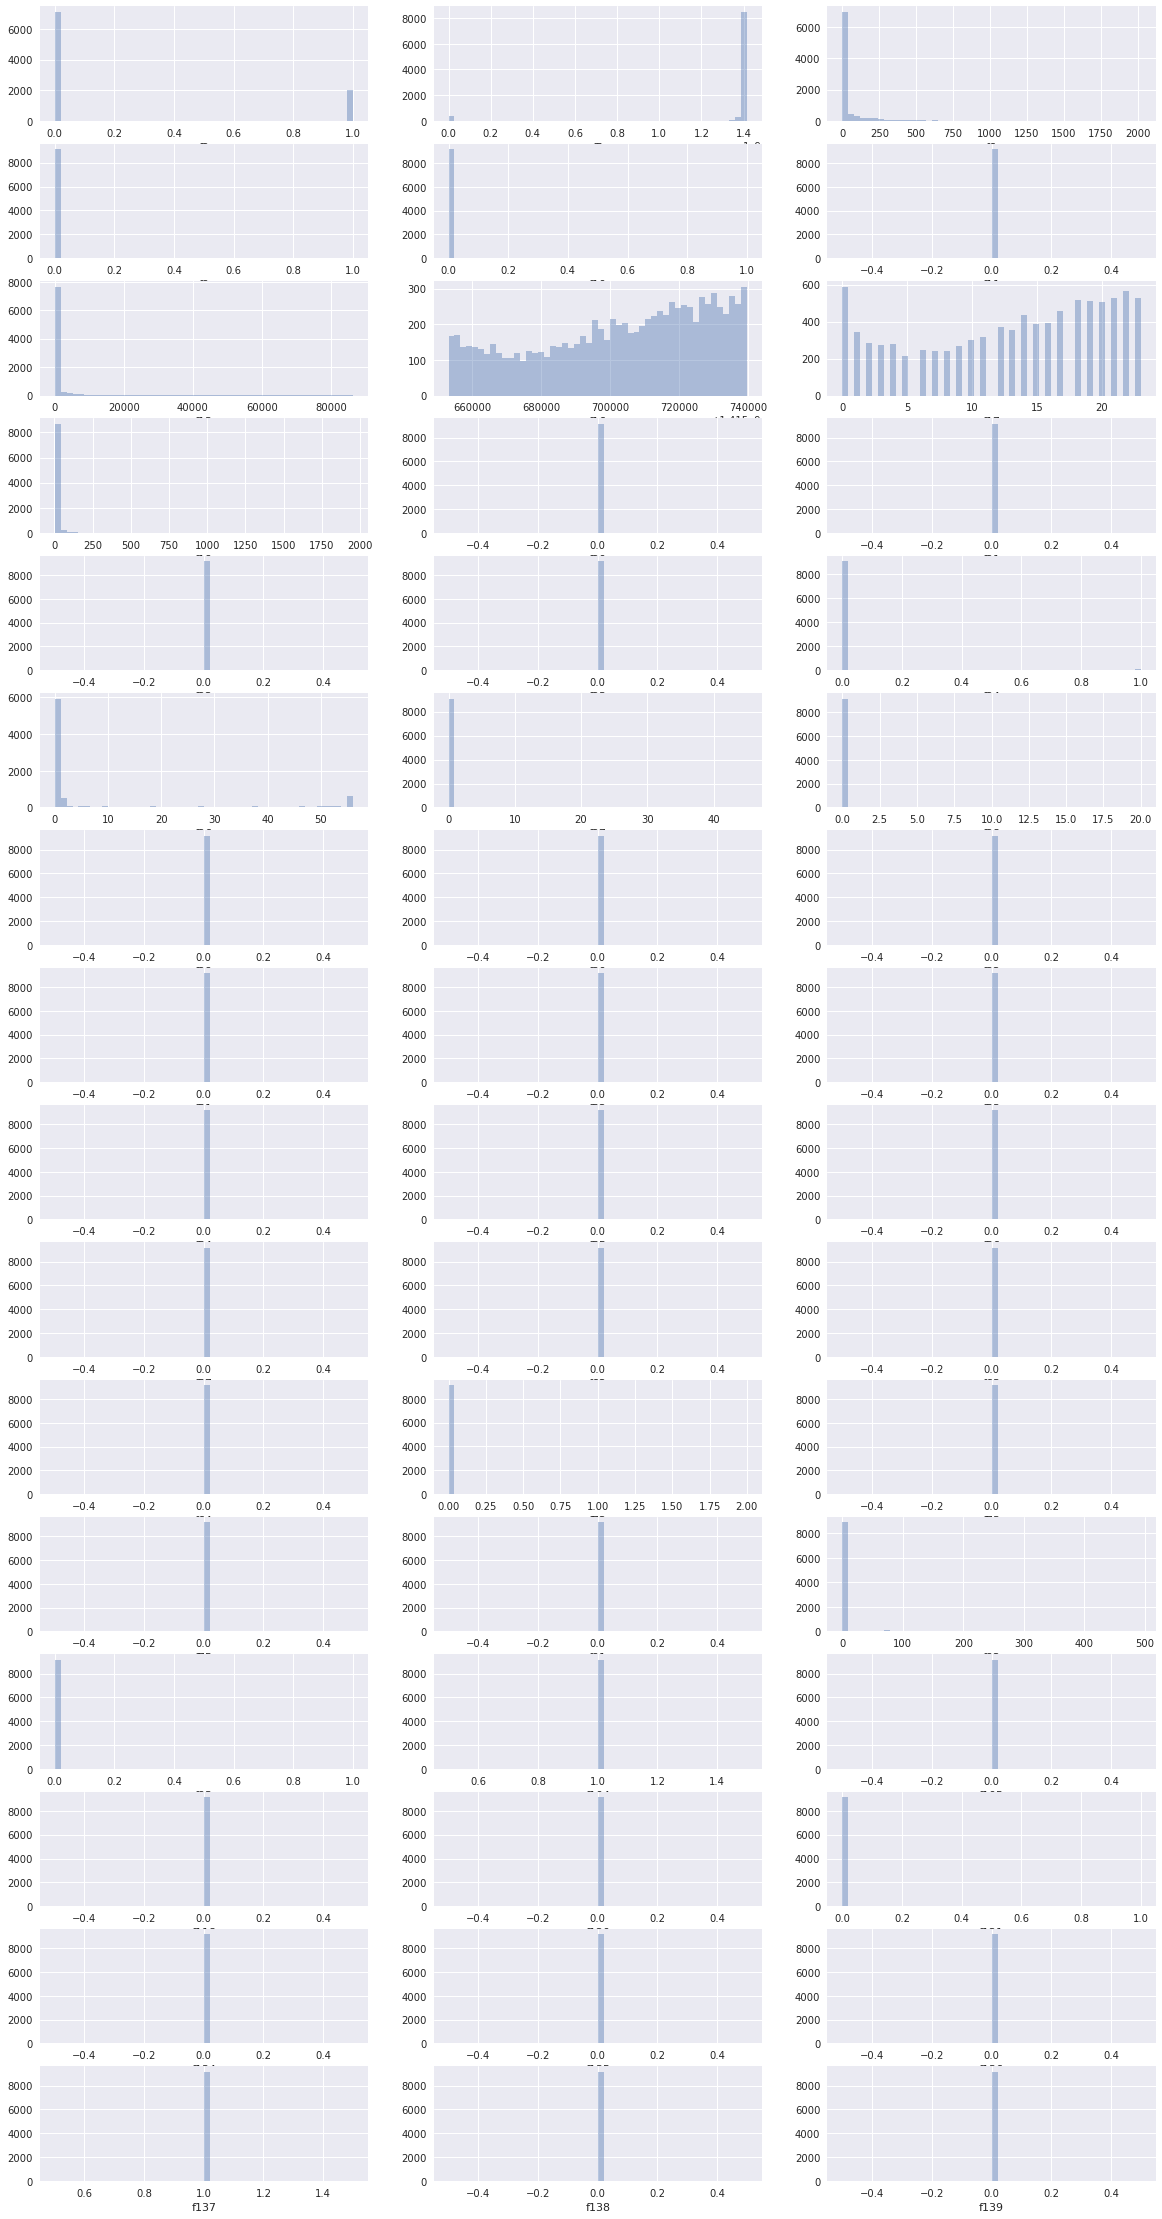

In [11]:
columns = df.columns.values

_, ax = plt.subplots(figsize=(20, 40), nrows=16, ncols=3)

for i in range(len(columns)):
    sns.distplot(df.iloc[:, i].dropna(), bins=50, kde=False, ax=ax[i // 3, i % 3])

### Unique values

In [12]:
columns_to_remove = []

for i in range(len(columns)):
    unique_count = len(df.iloc[:, i].unique())
    
    if unique_count == 1:
        columns_to_remove.append(columns[i])
    
    print("Unique values for {}: {}".format(columns[i], unique_count))

Unique values for f2: 2
Unique values for f5: 8652
Unique values for f6: 547
Unique values for f9: 2
Unique values for f10: 2
Unique values for f11: 1
Unique values for f13: 2319
Unique values for f16: 8648
Unique values for f17: 24
Unique values for f19: 220
Unique values for f20: 1
Unique values for f21: 1
Unique values for f22: 1
Unique values for f23: 1
Unique values for f24: 2
Unique values for f26: 57
Unique values for f27: 17
Unique values for f28: 5
Unique values for f29: 1
Unique values for f30: 1
Unique values for f32: 1
Unique values for f51: 1
Unique values for f52: 1
Unique values for f53: 1
Unique values for f54: 1
Unique values for f55: 1
Unique values for f56: 1
Unique values for f57: 1
Unique values for f62: 1
Unique values for f63: 1
Unique values for f64: 1
Unique values for f72: 3
Unique values for f73: 1
Unique values for f75: 1
Unique values for f91: 1
Unique values for f92: 57
Unique values for f93: 2
Unique values for f104: 1
Unique values for f105: 1
Unique val

In [13]:
df = df.drop(columns_to_remove, axis=1)
df.head()

,f2,f5,f6,f9,f10,f13,f16,f17,f19,f24,f26,f27,f28,f72,f92,f93,f121
0,0.0,1.415201e+09,5.0,0.0,0.0,25842.0,1.415737e+09,0.0,17.0,0.0,7.0,0.0,0.0,0.0,69.0,0.0,0.0
1,0.0,1.415123e+09,6.0,0.0,0.0,6989.0,1.415725e+09,20.0,175.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.411383e+09,49.0,0.0,0.0,74607.0,1.415729e+09,21.0,77.0,0.0,51.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.415724e+09,0.0,0.0,0.0,14.0,1.415724e+09,20.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.415695e+09,0.0,0.0,0.0,0.0,1.415695e+09,12.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


## Classification

In [14]:
params = {
    "objective": "binary:logistic",
    "silent": 1,
    "eta": 0.7,
    "max_depth": 6,
    "nthread": 10
}

In [15]:
X = df.as_matrix()[:, 1:]
Y = df.as_matrix()[:, 0]

In [16]:
spliter = StratifiedShuffleSplit(n_splits=1, test_size=0.8, random_state=0)
(test_indices, train_indices), = spliter.split(X, Y)

In [17]:
train_X, test_X = X[train_indices], X[test_indices]
train_Y, test_Y = Y[train_indices], Y[test_indices]

In [18]:
xgb_train = xgb.DMatrix(train_X, label=train_Y)
xgb_test = xgb.DMatrix(test_X, label=test_Y)

In [19]:
watchlist = [(xgb_train, "train"), (xgb_test, "test")]
num_round = 30
booster = xgb.train(params, xgb_train, num_round, watchlist)

[0]	train-error:0.164413	test-error:0.162295
[1]	train-error:0.163184	test-error:0.15847
[2]	train-error:0.161136	test-error:0.15847
[3]	train-error:0.161	test-error:0.15847
[4]	train-error:0.160863	test-error:0.159016
[5]	train-error:0.154855	test-error:0.157377
[6]	train-error:0.153626	test-error:0.160109
[7]	train-error:0.153216	test-error:0.160109
[8]	train-error:0.153216	test-error:0.160109
[9]	train-error:0.152806	test-error:0.160109
[10]	train-error:0.15226	test-error:0.159563
[11]	train-error:0.151987	test-error:0.160109
[12]	train-error:0.15185	test-error:0.159563
[13]	train-error:0.15185	test-error:0.159563
[14]	train-error:0.150212	test-error:0.159016
[15]	train-error:0.14789	test-error:0.159016
[16]	train-error:0.146388	test-error:0.159563
[17]	train-error:0.146388	test-error:0.159563
[18]	train-error:0.145842	test-error:0.159563
[19]	train-error:0.145569	test-error:0.159563
[20]	train-error:0.145296	test-error:0.159563
[21]	train-error:0.145296	test-error:0.159016
[22]	tra

In [20]:
values = booster.predict(xgb.DMatrix(test_X))
fraud = values > 0.5

In [21]:
precision = np.sum(fraud == test_Y) / len(test_Y)
print("Precision: {:0.3f}%".format(100 * precision))

Precision: 83.880%


In [22]:
recall = np.sum(np.logical_and(fraud, test_Y == 1)) / np.sum(test_Y == 1)
print("Recall: {:0.3f}%".format(100 * recall))

Recall: 85.049%


In [25]:
f1 = f1_score(test_Y, fraud)
print("F-1 score: {:0.3f}".format(f1))

F-1 score: 0.702
